### Analisis Finanzas 
#### Segundo desafio
¬øLos clientes con pr√©stamos e hipotecas tienden a tener un saldo medio m√°s bajo o m√°s riesgo de incumplimiento? ¬øC√≥mo deber√≠amos ajustar nuestras ofertas y estrategias de gesti√≥n de riesgos en funci√≥n de estos hallazgos?

#### Librerias y m√°s

In [2]:
"""Librer√≠as que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # An√°lisis y manipulaci√≥n de datos en tablas
import numpy as np                  # C√°lculos num√©ricos y matrices
import os                           # Gesti√≥n de rutas de archivos
import re                           # Expresiones regulares para b√∫squeda y manipulaci√≥n de texto

# Visualizaci√≥n de datos
import matplotlib.pyplot as plt     # Gr√°ficos b√°sicos en 2D
import seaborn as sns               # Gr√°ficos estad√≠sticos mejorados
import plotly.express as px         # Gr√°ficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gr√°ficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualizaci√≥n de diagramas de "treemap"

# Procesado y an√°lisis
from scipy import stats
from scipy.stats import chi2_contingency # Pruebas de hip√≥tesis y an√°lisis estad√≠stico
#Paleta de colores oficial
custom_palette = ["#2E2F36", "#5F6F81", "#AABBC8", "#DCE3EA", "#2CCED1"]

#### Carga de datos

In [3]:
df = pd.read_csv('../Data/df_250519.csv')

In [11]:
df.head()

Unnamed: 0  id  age         job  marital  education  default  balance  \
0           0   1   59      admin.  married  secondary    False     2343   
1           1   2   59      admin.  married  secondary    False     2343   
2           2   3   56      admin.  married  secondary    False       45   
3           3   4   41  technician  married  secondary    False     1270   
4           4   5   55    services  married  secondary    False     2476   

   housing   loan  ... day  month duration  campaign  pdays  previous  \
0     True  False  ...   5    May     1042         1     -1         0   
1     True  False  ...   5    May     1042         1     -1         0   
2    False  False  ...   5    May     1467         1     -1         0   
3     True  False  ...   5    May     1389         1     -1         0   
4     True  False  ...   5    May      579         1     -1         0   

   poutcome deposit        date            saldo_bin  
0   unknown    True  2024-05-05    (1958.1, 10763.2]  
1   unknown    True  2024-05-05    (1958.1, 10763.2]  
2   unknown    True  2024-05-05  (-6935.051, 1958.1]  
3   unknown    True  2024-05-05  (-6935.051, 1958.1]  
4   unknown    True  2024-05-05    (1958.1, 10763.2]  

[5 rows x 21 columns]

#### Tabla relacion Prestamos e hipotecas
Se analiza si tiene prestamo, si tiene hipoteca, Saldo medio y tasa de incumplimiento

   Tiene pr√©stamo  Tiene hipoteca  Saldo medio  Tasa incumplimiento  \
0           False           False  1844.047228             0.008864   
1           False            True  1365.205982             0.013876   
2            True           False   801.467991             0.057395   
3            True            True   773.169967             0.026403   

   N√∫mero de clientes  
0                7559  
1                6486  
2                 906  
3                1212  


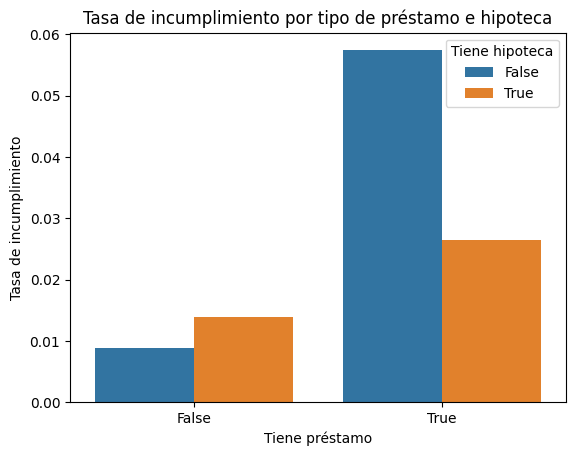

In [4]:
Tabla_agrupada = df.groupby(['loan', 'housing']).agg({'balance': 'mean','default': 'mean','id': 'count'}).reset_index()
Tabla_agrupada.columns = ['Tiene pr√©stamo', 'Tiene hipoteca', 'Saldo medio', 'Tasa incumplimiento', 'N√∫mero de clientes'] 
print(Tabla_agrupada)

'''Este grafico se puede cambiar de orden para mostrar lade manera inversa 
prestamo como Hue y hipoteca como x'''

sns.barplot(data=Tabla_agrupada, x='Tiene pr√©stamo', y='Tasa incumplimiento', hue='Tiene hipoteca')
plt.title("Tasa de incumplimiento por tipo de pr√©stamo e hipoteca")
plt.ylabel("Tasa de incumplimiento")
plt.show()

<Axes: xlabel='Tiene hipoteca', ylabel='Saldo medio'>

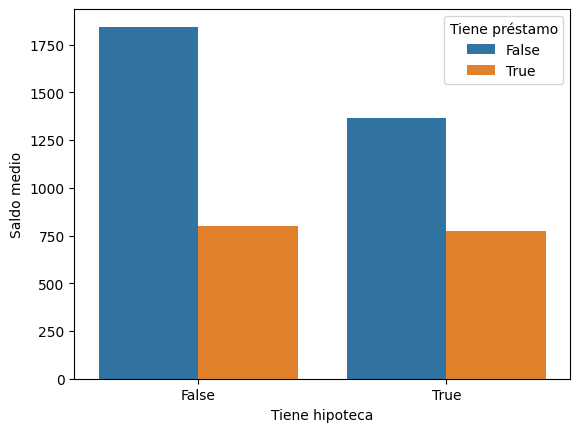

In [8]:
sns.barplot(data=Tabla_agrupada, x='Tiene hipoteca', y='Saldo medio', hue='Tiene pr√©stamo')

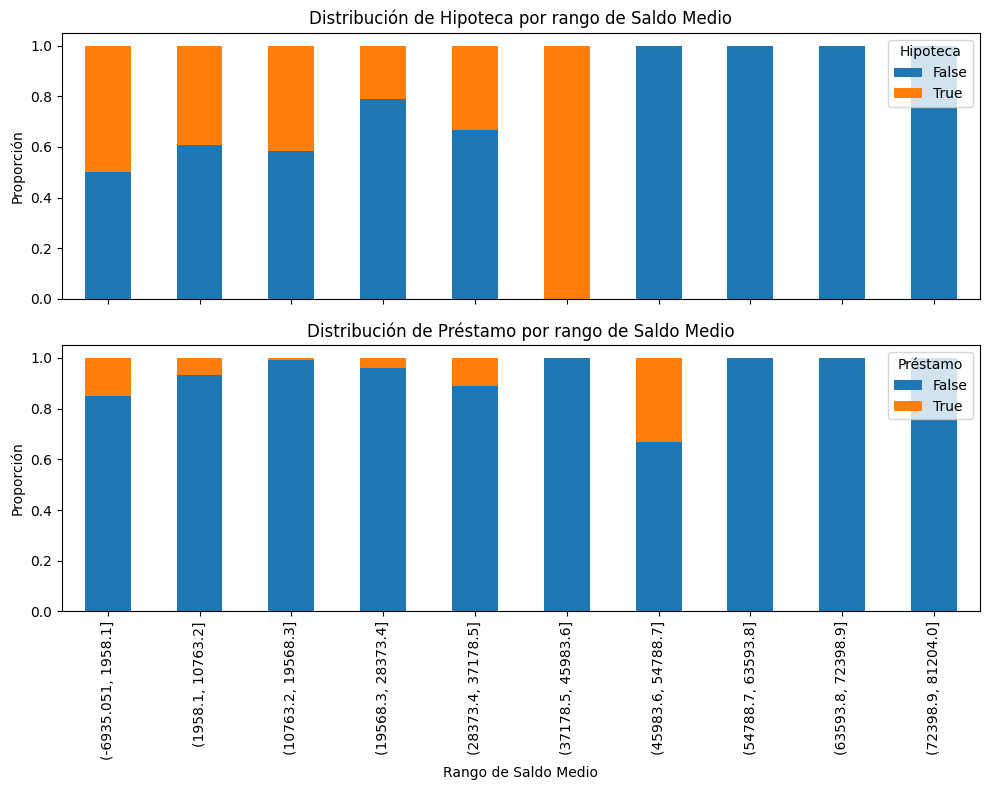

In [10]:
# Crear una variable de bins de saldo medio
df['saldo_bin'] = pd.cut(df['balance'], bins=10)

# Calcular proporciones de pr√©stamo e hipoteca por bin de saldo
pivot_housing = pd.crosstab(df['saldo_bin'], df['housing'], normalize='index')
pivot_loan = pd.crosstab(df['saldo_bin'], df['loan'], normalize='index')

# Crear el gr√°fico de subplots apilados
fig, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

# Hipoteca en eje Y superior
pivot_housing.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("Distribuci√≥n de Hipoteca por rango de Saldo Medio")
axes[0].set_ylabel("Proporci√≥n")
axes[0].legend(title="Hipoteca")

# Pr√©stamo en eje Y inferior
pivot_loan.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Distribuci√≥n de Pr√©stamo por rango de Saldo Medio")
axes[1].set_ylabel("Proporci√≥n")
axes[1].set_xlabel("Rango de Saldo Medio")
axes[1].legend(title="Pr√©stamo")

plt.tight_layout()
plt.show()


### Razon de monomios
chances de incumplimiento al tener un prestamo o hipoteca
La raz√≥n de momios (odds ratio) se calcula as√≠:
odds ratio = odds (evento) / odds (no evento) donde evento puede ser tanto prestamo como hipoteca
odds (evento) = p (evento) / (1 - p (evento))

In [6]:
def odds_ratio(df, column_a, column_b):
    """Calcula la raz√≥n de probabilidades (odds ratio) entre dos grupos."""
    tabla_contingencia = pd.crosstab(df[column_a],df[column_b] )
    A= tabla_contingencia.iloc[0, 0]
    B= tabla_contingencia.iloc[0, 1] 
    C= tabla_contingencia.iloc[1, 0]
    D= tabla_contingencia.iloc[1, 1]
    # Evitar divisiones por cero
    if B == 0 or D == 0:
        print("‚ö†Ô∏è Uno de los valores es cero, no se puede calcular la raz√≥n de momios.")
        return None
    odds_sin_evento = A / B
    odds_con_evento = C / D
    odds_ratio = odds_con_evento / odds_sin_evento
    print(f"üìä Tabla de contingencia entre '{column_a}' y '{column_b}':\n{tabla_contingencia}\n")
    print(f"odds_sin_{column_a}: {odds_sin_evento}")
    print(f"odds_con_{column_a} : {odds_con_evento}")
    print(f"odds_ratio: {odds_ratio}")
    
# aplicar la funci√≥n a los datos
odds_ratio(df, 'loan', 'default')
odds_ratio(df, 'housing', 'default')


üìä Tabla de contingencia entre 'loan' y 'default':
default  False  True 
loan                 
False    13888    157
True      2034     84

odds_sin_loan: 88.45859872611464
odds_con_loan : 24.214285714285715
odds_ratio: 0.2737358048057933
üìä Tabla de contingencia entre 'housing' y 'default':
default  False  True 
housing              
False     8346    119
True      7576    122

odds_sin_housing: 70.1344537815126
odds_con_housing : 62.09836065573771
odds_ratio: 0.8854187536583737


### Chi cuadrado
comprobar la relaciond variables categoricas

In [7]:
# Funci√≥n para ejecutar Chi-cuadrado entre default y una variable categ√≥rica
def Funcion_Chi2(df, column):
    Tabla_contingencia = pd.crosstab(df[column], df['default'])
    chi2, p, dof, expected = chi2_contingency(Tabla_contingencia)
    print(f"\nTest Chi-cuadrado entre '{column}' y 'default'")
    print("Tabla de contingencia:\n", Tabla_contingencia)
    print(f"Chi2 = {chi2:.4f}, p-valor = {p:.4f}, grados de libertad = {dof}")
    if p < 0.05:
        print("‚ùóHay evidencia estad√≠stica de asociaci√≥n entre las variables.")
    else:
        print("‚úÖ No se detecta asociaci√≥n estad√≠sticamente significativa.")

# Aplicar a 'loan' y 'housing'
Funcion_Chi2(df, 'loan')
Funcion_Chi2(df, 'housing')


Test Chi-cuadrado entre 'loan' y 'default'
Tabla de contingencia:
 default  False  True 
loan                 
False    13888    157
True      2034     84
Chi2 = 99.7154, p-valor = 0.0000, grados de libertad = 1
‚ùóHay evidencia estad√≠stica de asociaci√≥n entre las variables.

Test Chi-cuadrado entre 'housing' y 'default'
Tabla de contingencia:
 default  False  True 
housing              
False     8346    119
True      7576    122
Chi2 = 0.7622, p-valor = 0.3826, grados de libertad = 1
‚úÖ No se detecta asociaci√≥n estad√≠sticamente significativa.


# KPIs

- saldo medio gral
- saldo medio por decil
- % clientes por tsa de riesgo
- % clientes con hipoteca
- % clientes con pr√©stamo
- tasa incumplimiento
- tasa contrataci√≥n dep√≥sito